In [1]:
# Importing all libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def convert_to_categorical(label):
    # Convert integer label to categorical format
    categorical_label = np.zeros((4), dtype=int)
    categorical_label[label] = 1
    return categorical_label

In [3]:
def load_images(path, label_mapping):
    # Load images and corresponding labels from the given path
    images = []
    labels = []
    for directory in os.listdir(path):
        sub_directory_path = os.path.join(path, directory)
        file_counter = 0
        for img_name in os.listdir(sub_directory_path):
            img_path = os.path.join(sub_directory_path, img_name)
            if os.path.isfile(img_path):
                file_counter += 1
                img_file = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (150, 150))
                img_file2 = cv2.resize(cv2.imread(img_path), (224, 224))
                images.append((img_file, img_file2))
                labels.append(convert_to_categorical(label_mapping[directory]))

        print(f'The directory {directory} has {file_counter} samples.')

    return images, labels

In [4]:
def preprocess_images(images, is_cnn=True):
    # Preprocess images and convert to array
    processed_images = np.array([image / 255.0 for image in images])
    if is_cnn:
        processed_images = processed_images[:, :, :, np.newaxis]
    return processed_images

In [5]:
# Define paths for training and testing data
train_path = 'Brain_tumor_MRI/Training'
test_path = 'Brain_tumor_MRI/Testing'

# Get subdirectories and create a mapping of labels to integers
subdirectories = os.listdir(train_path)
label_mapping = {subdirectories[i]: i for i in range(len(subdirectories))}

# Load and preprocess training and testing data
print("Training Samples")
train_data, train_labels = load_images(train_path, label_mapping)
print("Testing Samples")
test_data, test_labels = load_images(test_path, label_mapping)

x_train_mobilenet = preprocess_images([item[1] for item in train_data], is_cnn=False)

x_test_mobilenet = preprocess_images([item[1] for item in test_data], is_cnn=False)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

Training Samples
The directory glioma has 1321 samples.
The directory meningioma has 1339 samples.
The directory notumor has 1595 samples.
The directory pituitary has 1457 samples.
Testing Samples
The directory glioma has 300 samples.
The directory meningioma has 306 samples.
The directory notumor has 405 samples.
The directory pituitary has 300 samples.


In [6]:
# Print information summary, and display a sample training and test image.
print()

print(f'The shape of x_train_mobilenet is {x_train_mobilenet.shape}.')
print(f'The shape of x_test_mobilenet is {x_test_mobilenet.shape}.\n')

print(f'The total number of training samples is {len(y_train)}.')
print(f'The total number of testing samples is {len(y_test)}.\n')


The shape of x_train_mobilenet is (5712, 224, 224, 3).
The shape of x_test_mobilenet is (1311, 224, 224, 3).

The total number of training samples is 5712.
The total number of testing samples is 1311.



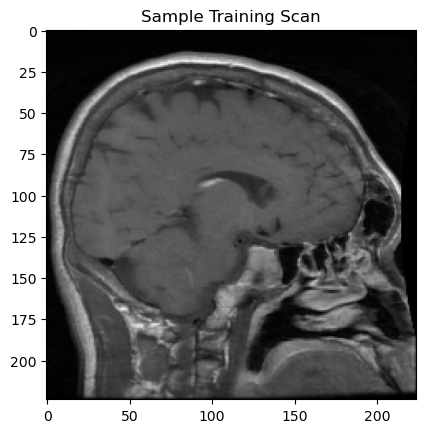

In [7]:
# Display a sample training image
n1 = random.randint(0, len(y_train))
plt.imshow(x_train_mobilenet[n1], cmap='gray')
plt.title('Sample Training Scan')
plt.show()

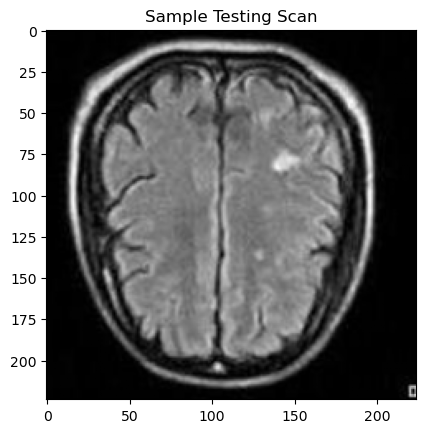

In [8]:
# Display a sample testing image
n2 = random.randint(0, len(x_test_mobilenet))
plt.imshow(x_test_mobilenet[n2], cmap='gray')
plt.title('Sample Testing Scan')
plt.show()

In [9]:
# Create the Transfer Learning model using MobileNetV2 with added Dense layers
mobilenet_model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model_base.trainable = False
x = mobilenet_model_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Added Dense layer
x = Dense(64, activation='relu')(x)   # Added Dense layer
x = Dense(32, activation='relu')(x)   # Added Dense layer
output_layer = Dense(4, activation='softmax')(x)  # Output layer with 4 classes

mobilenet_model = Model(inputs=mobilenet_model_base.input, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9)
mobilenet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

mobilenet_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_2_add[0][0]']         
                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_d

 )                                                                                                
                                                                                                  
 block_6_depthwise (Depthwi  (None, 14, 14, 192)          1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
          

 block_9_project (Conv2D)    (None, 14, 14, 64)           24576     ['block_9_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
          

                                                                                                  
 block_13_expand (Conv2D)    (None, 14, 14, 576)          55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 14, 14, 576)          2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)       

                                                                                                  
 block_16_expand_relu (ReLU  (None, 7, 7, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_

In [10]:
import time

# Measure the time taken for training
start_time = time.time()

# Train the MobileNetV2 model
train_mobilenet_v2 = mobilenet_model.fit(x_train_mobilenet, y_train, epochs=50, batch_size=64)

# Save the trained model
mobilenet_model.save('mobilenet_model')

# Calculate the time taken for training
end_time = time.time()
training_time_minutes = round((end_time - start_time) / 60)

# Display training time
print()
print(f'The training of 50 epochs of the MobileNet model took {training_time_minutes} minutes.')

Epoch 1/50


90/90 [==============================] - 49s 477ms/step - loss: 0.4673 - accuracy: 0.8269
Epoch 2/50
90/90 [==============================] - 44s 488ms/step - loss: 0.2335 - accuracy: 0.9156
Epoch 3/50
90/90 [==============================] - 42s 464ms/step - loss: 0.1694 - accuracy: 0.9380
Epoch 4/50
90/90 [==============================] - 41s 456ms/step - loss: 0.1389 - accuracy: 0.9477
Epoch 5/50
90/90 [==============================] - 41s 460ms/step - loss: 0.1049 - accuracy: 0.9615
Epoch 6/50
90/90 [==============================] - 41s 451ms/step - loss: 0.0876 - accuracy: 0.9683
Epoch 7/50
90/90 [==============================] - 42s 461ms/step - loss: 0.0788 - accuracy: 0.9715
Epoch 8/50
90/90 [==============================] - 41s 461ms/step - loss: 0.0590 - accuracy: 0.9795
Epoch 9/50
90/90 [==============================] - 44s 487ms/step - loss: 0.0533 - accuracy: 0.9783
Epoch 10/50
90/90 [==============================] - 42s 466ms/step - loss: 0.0318 - accu

INFO:tensorflow:Assets written to: mobilenet_model\assets



The training of 50 epochs of the MobileNet model took 36 minutes.


In [11]:
# Evaluate the model on the testing data
val_loss_mobilenet_v2, val_accuracy_mobilenet_v2 = mobilenet_model.evaluate(x_test_mobilenet, y_test)

# Display evaluation results
print()
print(f'The loss of the MobileNet model is {round(val_loss_mobilenet_v2, 4)} '
      f'while its accuracy on testing data is {round(100 * val_accuracy_mobilenet_v2, 2)}%.')

41/41 [==============================] - 11s 234ms/step - loss: 0.2232 - accuracy: 0.9626

The loss of the MobileNet model is 0.2232 while its accuracy on testing data is 96.26%.


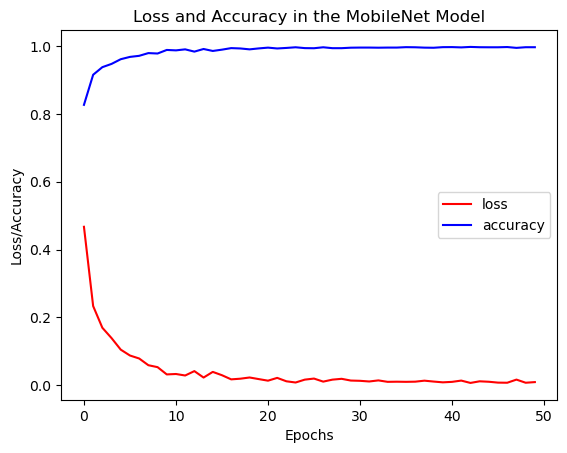

In [12]:
# Plot training history (loss and accuracy)
plt.plot(train_mobilenet_v2.history["loss"], c="red")
plt.plot(train_mobilenet_v2.history["accuracy"], c="blue")
plt.title("Loss and Accuracy in the MobileNet Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend(['loss', 'accuracy'])
plt.show()

41/41 [==============================] - 11s 249ms/step


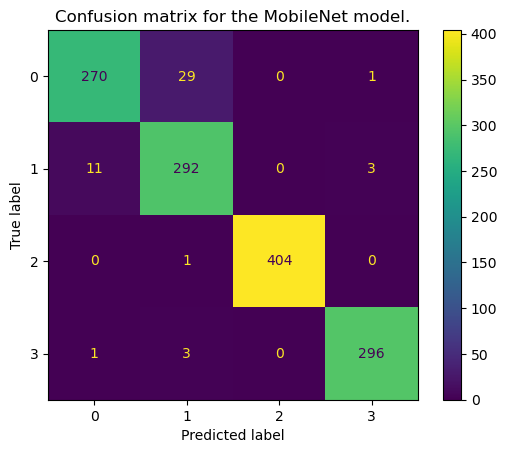

In [13]:
# Make predictions on the testing data
predictions_mobilenet_v2 = np.argmax(mobilenet_model.predict(x_test_mobilenet), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Display confusion matrix
confusion_matrix_display_mobilenet_v2 = ConfusionMatrixDisplay(confusion_matrix(true_labels, predictions_mobilenet_v2))
confusion_matrix_display_mobilenet_v2.plot()
confusion_matrix_display_mobilenet_v2.ax_.set_title("Confusion matrix for the MobileNet model.")
plt.show()